In [55]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from simulation.network2 import AttractorNetwork, Langevin, get_all_attractors, relax
from joblib import Parallel, delayed
from copy import deepcopy
from tqdm import tqdm


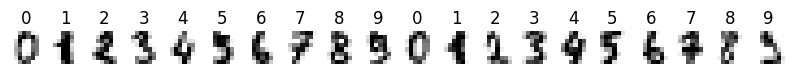

In [56]:
digits = datasets.load_digits(as_frame=True)
_, axes = plt.subplots(nrows=1, ncols=20, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

In [57]:
# one epoch of training (with one patterns)
def continous_inference_and_learning(nw, data, inverse_temperature=0.4, learning_rate=0.01, num_iterations=100, coef_noise=0):

    error = []
    prev_J = nw.get_J()

    data_noisy = data + np.random.normal(0, coef_noise, data.shape)

    for i, node in enumerate(nw.sigmas):
        node.bias = data_noisy[i]

    activations = []
    for i in range(num_iterations):
        nw.update(inverse_temperature=inverse_temperature, learning_rate=learning_rate, least_action=False)
        activations.append([node.activation for node in nw.sigmas])
        error.append( np.sum(np.power(nw.get_J() - prev_J, 2)))
        prev_J = nw.get_J()

    # clean up
    for i, node in enumerate(nw.sigmas):
        node.bias = 0

    return activations, error

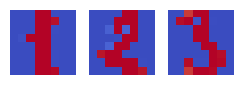

<Axes: ylabel='Count'>

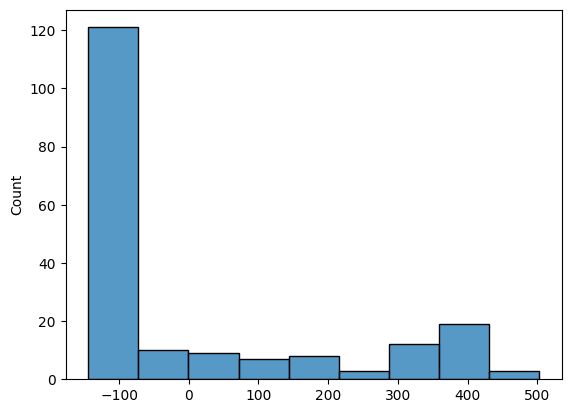

In [58]:
data = digits.data.values[1:4]
data = np.power(data, 2)
data = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)
data *= 200

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < data.shape[0]:
        image = data[i].reshape(8, 8) + np.random.normal(0, 0.1, (8,8)) 
        for j in range(image.shape[0]):
            for k in range(image.shape[1]):
                image[j, k] = Langevin(image[j, k])

        ax.imshow(image, cmap="coolwarm", interpolation="nearest", vmin=-np.max(image), vmax=np.max(image))
        ax.set_axis_off()
    else:
        ax.set_visible(False)

plt.show()
sns.histplot(data.flatten())

In [59]:
size = data.shape[1]
num_variables = data.shape[0]
J = np.zeros((size, size))
nw = AttractorNetwork(J, biases = np.zeros(J.shape[0]))

error = []
pattern = []

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [13:53<00:00, 119.95it/s]


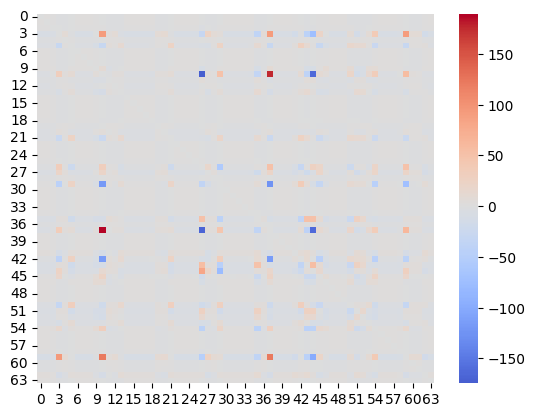

<Axes: >

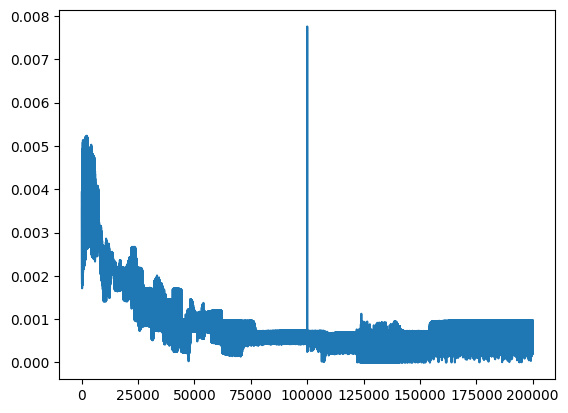

In [115]:
num_iterations = 100000
num_runs = 1 

for i in tqdm(range(num_iterations)):
    di = i % data.shape[0] #np.random.randint(0, data.shape[0])
    pattern.append(di)
    acts, e = continous_inference_and_learning(nw, data[di], coef_noise=0.0, inverse_temperature=0.5, 
                            learning_rate=0.001, num_iterations=num_runs)
    error += e
sns.heatmap(nw.get_J(), cmap="coolwarm", center=0)
plt.show()
sns.lineplot(np.array(error))
#for i, pattern_idx in enumerate(pattern):
#    plt.text(i*num_runs, max(error[i*num_runs:i*num_runs+num_runs]), str(pattern_idx), ha='center', va='bottom')


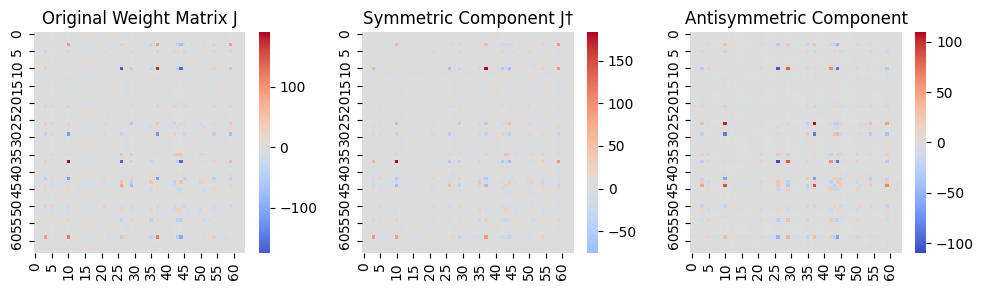

Asymmetry measure: 1.282726


In [118]:
# Symmetrize the weight matrix J
J = nw.get_J()
J_symmetrized = 0.5 * (J + J.T)  # J_ij† = (1/2) * (J_ij + J_ji)

# Display the original and symmetrized weight matrices
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
sns.heatmap(J, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Original Weight Matrix J")

sns.heatmap(J_symmetrized, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Symmetric Component J†")


# Calculate the asymmetric component of the weight matrix
J_asymmetric = 0.5 * (J - J.T)  # J_ij‡ = (1/2) * (J_ij - J_ji)

# Display the asymmetric component
sns.heatmap(J_asymmetric, cmap="coolwarm", center=0, ax=axes[2])
axes[2].set_title("Antisymmetric Component")
plt.tight_layout()
plt.show()



# Calculate and print the asymmetry measure
asymmetry = np.linalg.norm(J - J.T) / np.linalg.norm(J)
print(f"Asymmetry measure: {asymmetry:.6f}")


/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_45921/4240155354.py:8: RuntimeWarning: invalid value encountered in sqrt
  Q = eigenvectors @ np.diag(np.sqrt(eigenvalues)) # only the positive eigenvalues survive, See Kanter, I., & Sompolinsky, H. (1987).


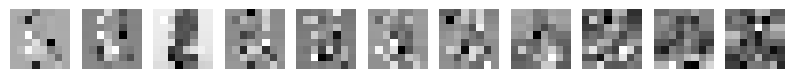

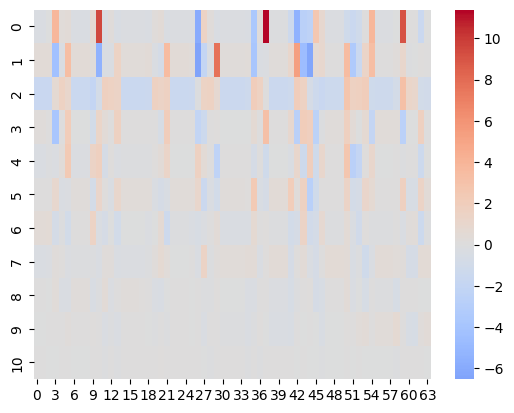

<Axes: >

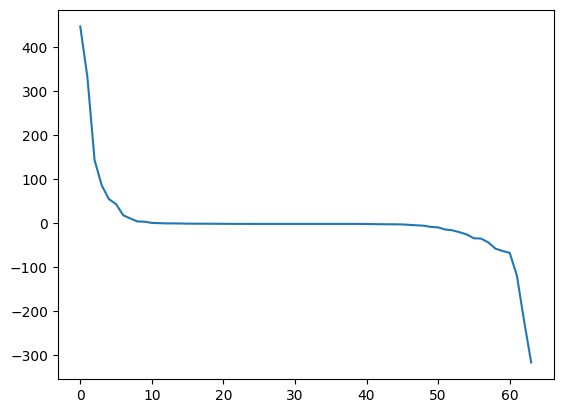

In [119]:
# Eigenvalue decomposition of J
eigenvalues, eigenvectors = np.linalg.eigh(nw.get_J())
# Sort eigenvalues and corresponding eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
# Compute the weight matrix Q?
Q = eigenvectors @ np.diag(np.sqrt(eigenvalues)) # only the positive eigenvalues survive, See Kanter, I., & Sompolinsky, H. (1987).

Q = Q[:, :np.sum(eigenvalues > 0)].T # drop na-s, basically, and transpose

#best_matches = []
#for i in range(Q.shape[0]):
#    best_match = -1
#    best_match_index = -1
#    for j in range(data.shape[0]):
#        corr = np.abs(np.corrcoef(Q[i, :], data[j, :])[0, 1])
#        if corr > best_match:
#            best_match = corr
#            best_match_index = j
#    print(f"Best match for column {i} is {best_match_index} with correlation {best_match}")
#    best_matches.append(best_match_index)
#Q_sorted = Q[best_matches, :]
Q_sorted = Q

fig, ax = plt.subplots(1, np.sum(eigenvalues > 0), figsize=(10, 3))
for i in range(np.sum(eigenvalues > 0)):
    ax[i].set_axis_off()
    if Q_sorted[0, i] > 0:
        ax[i].imshow(Q_sorted[i, :].reshape(digits.images.shape[1], digits.images.shape[2]), cmap="gray", interpolation="nearest")
    else:
        ax[i].imshow(Q_sorted[i, :].reshape(digits.images.shape[1], digits.images.shape[2]), cmap="gray_r", interpolation="nearest")
    #ax[i].set_title(f"eigenvalue {eigenvalues[i]}")

plt.show()
sns.heatmap(Q, cmap="coolwarm", center=0)
plt.show()
sns.lineplot(eigenvalues)

In [120]:
eigenvalues

array([ 4.46866304e+02,  3.31254946e+02,  1.43042028e+02,  8.55507833e+01,
        5.44266251e+01,  4.29275804e+01,  1.77504889e+01,  1.03318109e+01,
        3.51182015e+00,  3.00968902e+00,  2.62563655e-01, -2.18414752e-01,
       -7.97324200e-01, -8.72185730e-01, -1.04386253e+00, -1.38508143e+00,
       -1.46776573e+00, -1.53866605e+00, -1.59007018e+00, -1.68361745e+00,
       -1.75904492e+00, -1.90173152e+00, -1.92575853e+00, -1.92838371e+00,
       -1.95703961e+00, -1.95970271e+00, -1.95984869e+00, -1.96010781e+00,
       -1.96028477e+00, -1.96089323e+00, -1.96092352e+00, -1.96157805e+00,
       -1.96203400e+00, -1.96218236e+00, -1.96240410e+00, -1.96262856e+00,
       -1.96325482e+00, -1.96517801e+00, -1.96552224e+00, -2.00808702e+00,
       -2.22939818e+00, -2.46950732e+00, -2.71344440e+00, -2.78515473e+00,
       -2.87771418e+00, -3.16224757e+00, -4.20915291e+00, -5.15340993e+00,
       -6.03358767e+00, -8.79779463e+00, -9.98417155e+00, -1.46561551e+01,
       -1.65876977e+01, -

In [65]:
# projection network Sompolensky

In [127]:
acts, err = continous_inference_and_learning(nw, np.zeros(data.shape[1]), coef_noise=0.0, inverse_temperature=0.1, 
                            learning_rate=0, num_iterations=100)

In [128]:
for i in range(Q.shape[0]):
    for j, node in enumerate(nw.sigmas):
        node.activation = Q[i, j]
    print(nw.energy())

    

-84652.32215686789
-22365.975265838948
-7295.227916106334
-1295.5113073098325
252.22558097209273
412.95350205896466
160.17709463868152
98.67510725793014
16.68897303714656
12.920930084834337
0.9460567389005842


In [129]:
for i in range(10):
    for j, node in enumerate(nw.sigmas):
        node.activation = acts[i][j]
    print(nw.energy())

-1818.7133614551656
-2976.824017525466
-2910.1938537685664
-2039.8523461524708
-3207.3024202278634
-2949.1255780224333
-3751.3797247197117
-3388.655771788978
-3539.2747168409687
-3620.698597204586


In [130]:
for i in range(Q.shape[0]):
    permuted_indices = np.random.permutation(Q.shape[1])
    for j, node in enumerate(nw.sigmas):
        node.activation = Q[i, permuted_indices[j]]
    print(nw.energy())

1612.301784576568
230.32986487737946
1602.1258861409483
395.5475789565363
211.10885866705968
331.6685864402914
232.50180512463425
117.76975642617751
30.820877126260548
-1.9739909271815925
2.2565809599163504


In [131]:
for i in range(Q.shape[0]):
    for j, node in enumerate(nw.sigmas):
        node.activation = np.random.uniform(-1, 1)
    print(nw.energy())

129.322330329154
-50.94416041737478
-123.57491802405706
-48.014745374474906
141.4352647844923
76.67368851160194
-93.35083135085908
-54.30227870527821
27.394485511584165
55.88640910207569
-1.0989253887246448


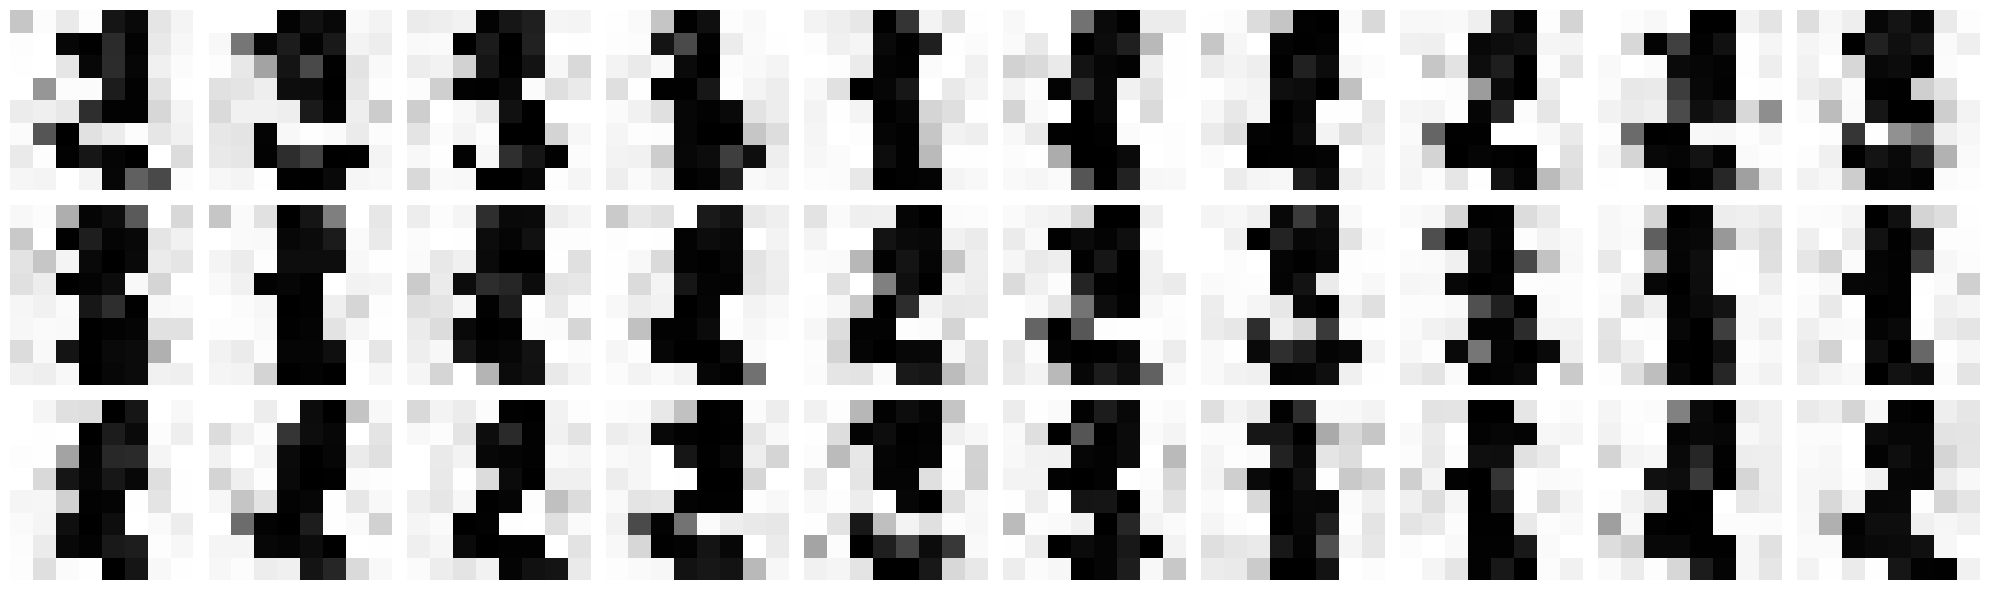

In [134]:
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.heatmap(np.array(np.array(acts[i+3])).reshape(8,8), cmap="gray", ax=ax, cbar=False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [135]:
activations = np.array(acts)

from joblib import Parallel, delayed

def calculate_energy(activation_vector, J_matrix):
    tmp_nw = AttractorNetwork(J_matrix, biases=np.zeros(J_matrix.shape[0]))
    for j, node in enumerate(tmp_nw.sigmas):
        node.activation = activation_vector[j]
    return tmp_nw.energy()

# Parallelize the energy calculation
energies = Parallel(n_jobs=-1)(
    delayed(calculate_energy)(activations[i], nw.get_J()) 
    for i in range(activations.shape[0])
)


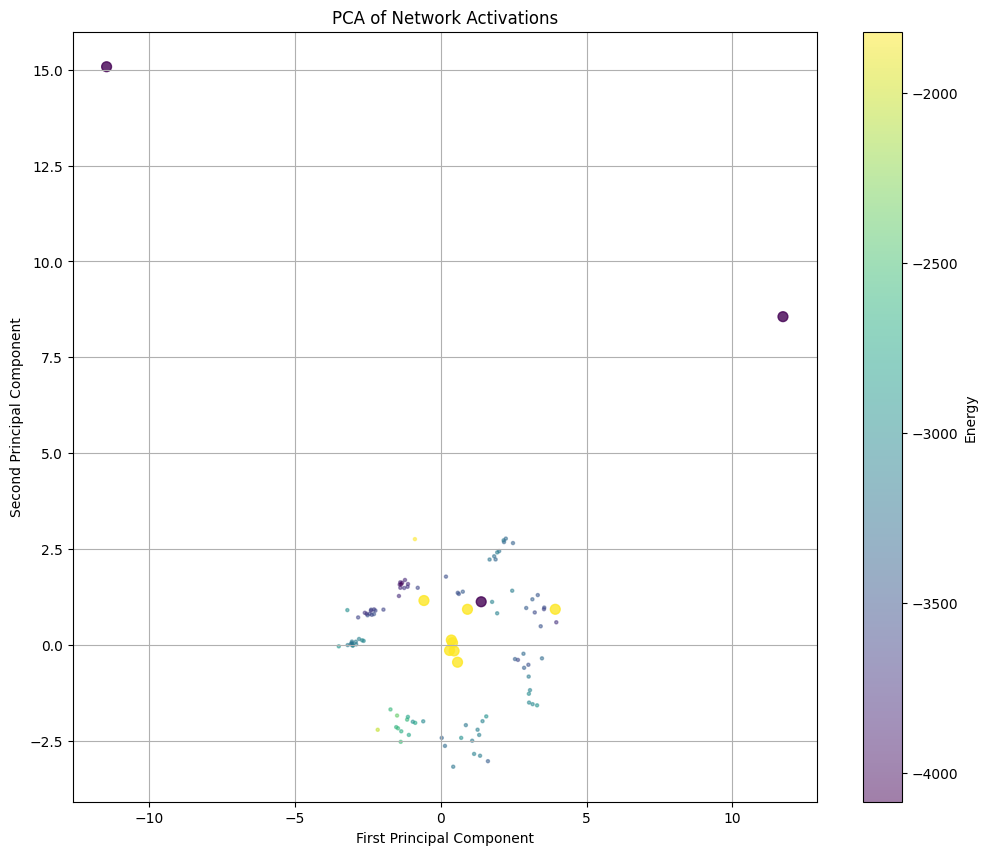

In [136]:
activations = acts

# Perform PCA on the activations
from sklearn.decomposition import PCA

# Standardize the data (optional but recommended for PCA)
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#activations_scaled = scaler.fit_transform(activations)

# Apply PCA
pca = PCA(n_components=10)  # Start with 10 components
activations_pca = pca.fit_transform(activations)

# Plot the explained variance ratio
#plt.figure(figsize=(10, 6))
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('Number of Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.title('Explained Variance vs. Number of Components')
#plt.grid(True)
#plt.show()

# Plot the first two principal components
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(activations_pca[:, 0], activations_pca[:, 1], 
                     c=energies, 
                     alpha=0.5, s=5, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Network Activations')
plt.grid(True)
# Add colorbar with the correct axes reference
cbar = fig.colorbar(scatter, ax=ax, label='Energy')

# Project Q using the same PCA model
Q_pca = pca.transform(Q)

# Calculate energy for each pattern in Q
Q_energies = Parallel(n_jobs=-1)(
    delayed(calculate_energy)(Q[i], nw.get_J()) 
    for i in range(Q.shape[0])
)

# Add a second subplot to show the projection of Q
scatter_Q = ax.scatter(Q_pca[:, 0], Q_pca[:, 1], 
                       c=Q_energies, 
                       alpha=0.8, s=50, cmap='viridis', vmin=min(energies), vmax=max(energies))

plt.show()

<Axes: ylabel='Count'>

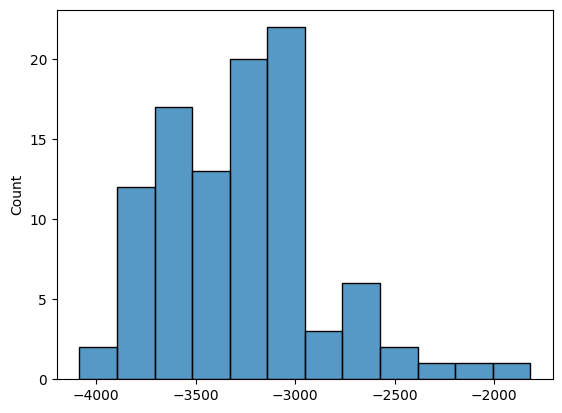

In [137]:
sns.histplot(energies)

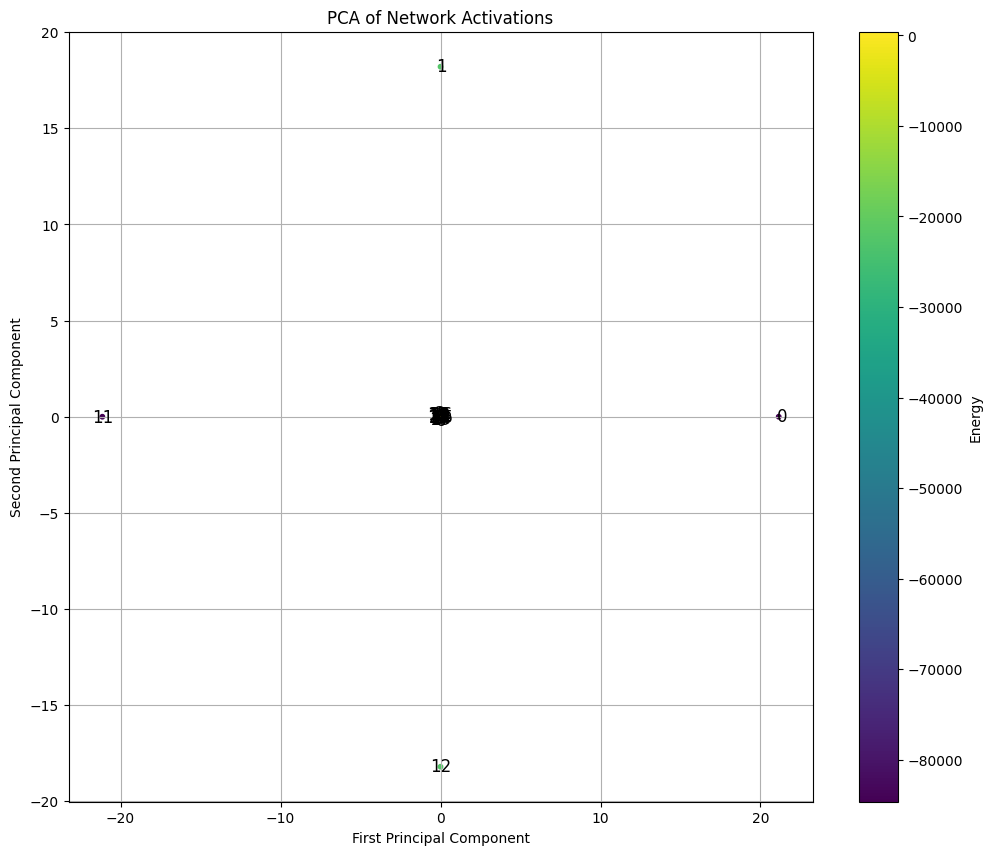

In [138]:
activations = acts

# Perform PCA on the activations
from sklearn.decomposition import PCA

# Standardize the data (optional but recommended for PCA)
#from sklearn.preprocessing impor
# t StandardScaler
#scaler = StandardScaler()
#activations_scaled = scaler.fit_transform(activations)

# Apply PCA
pca = PCA(n_components=3)  # Start with 10 components
activations_pca = pca.fit_transform(np.vstack((Q, -Q)))

# Plot the explained variance ratio
#plt.figure(figsize=(10, 6))
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('Number of Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.title('Explained Variance vs. Number of Components')
#plt.grid(True)
#plt.show()

# Calculate energies for the combined Q and -Q data
combined_Q = np.vstack((Q, -Q))
combined_energies = Parallel(n_jobs=-1)(
    delayed(calculate_energy)(combined_Q[i], nw.get_J()) 
    for i in range(combined_Q.shape[0])
)


# Plot the first two principal components
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(activations_pca[:, 0], activations_pca[:, 1], 
                     c=combined_energies, 
                     alpha=1, s=10, cmap='viridis')



# Add labels for each point (its index)
for i, (x, y) in enumerate(zip(activations_pca[:, 0], activations_pca[:, 1])):
    ax.text(x+np.random.normal(0, 0.1), y+np.random.normal(0, 0.1), str(i), fontsize=12, ha='center', va='center')

# Add a colorbar to show energy values
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Energy')


plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Network Activations')
plt.grid(True)

plt.show()

In [142]:
from simulation.network import inverse_Langevin

#J_demean = nw.get_J() - np.mean(nw.get_J())
attractors = []
frequencies = []

def workhorse(nw_relax, data_shape, seed):
    rng=np.random.default_rng(seed)
    nw_relax = AttractorNetwork(nw.get_J(), biases = np.zeros(nw.get_J().shape[0]), rng=rng)
    # Randomly initialize activation
    random_activation = rng.uniform(-0.5, 0.5, data_shape) 
    #random_index = np.random.randint(0, num_variables)
    #random_activation = np.copy(data[random_index]) + rng.normal(0, 0.1, data.shape[1]) 
    random_activation = [Langevin(x) for x in random_activation]
    #for ni, node in enumerate(nw_relax.sigmas):
    #    node.bias =random_activation[ni] * 1
    attractor, steps = relax(nw_relax, input=random_activation, #bias=inverse_Langevin(0.6 * base_A),
                              inverse_temperature=1, least_action=True, max_steps=1000, tol=0.000000000001)
    print(steps)
    
    # Normalize attractor orientation
    #if np.sum(attractor.reshape(8, 8)[:, 0]) > 0:
    #    attractor *= -1
        
    return attractor

# Run parallel jobs
n_jobs = -1  # Use all available cores
total_runs = 16
results = Parallel(n_jobs=n_jobs)(
    delayed(workhorse)(nw, data.shape[1], i) 
    for i in range(total_runs)
)

# Process results to find unique attractors
for attractor in results:
    # Check if attractor is already in the list using correlation
    if not any(abs(np.corrcoef(attractor, existing)[0, 1]) >= 0.9 for existing in attractors):
        attractors.append(attractor)
        frequencies.append(1)
    else:
        max_corr_index = np.argmax([abs(np.corrcoef(attractor, existing)[0, 1]) for existing in attractors])
        frequencies[max_corr_index] += 1

# Sort attractors and frequencies based on frequency in decreasing order
sorted_indices = np.argsort(frequencies)[::-1]
attractors = [attractors[i] for i in sorted_indices]
frequencies = [frequencies[i] for i in sorted_indices]

frequencies

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

nan nan


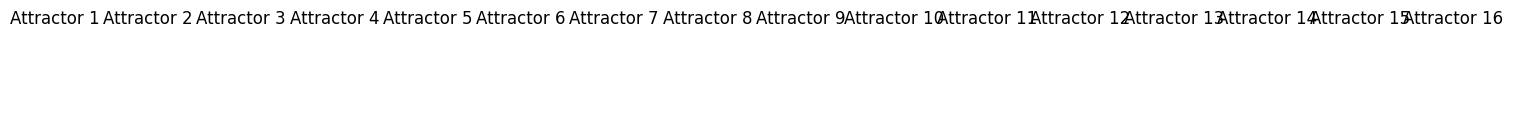

In [143]:
if len(attractors) > 0:
    fig, axes = plt.subplots(1, len(attractors)+1, figsize=(16, 16))
    #axes = axes.flatten()
    
    for i, attractor in enumerate(attractors):
        img = attractor.reshape(8, 8)
        axes[i].imshow(img, cmap='gray_r')
        axes[i].set_title(f'Attractor {i+1}')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_axis_off()

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    print(attractor.min(), attractor.max())

    plt.tight_layout()
    plt.show()
else:
    print("No attractors found.")


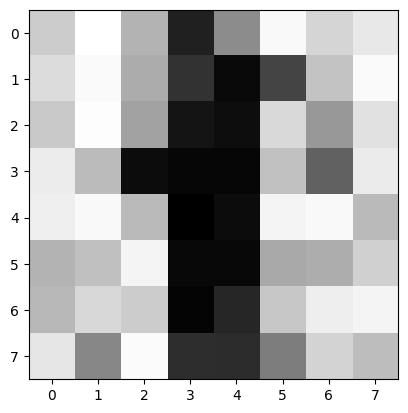

-929.1888496755068
-2248.9404539667094
-2919.6577048782874
-2464.6121288973736
-1530.826284797901
-2451.5317486522326
-2393.3302700728364
-2633.2129881785627
-2355.624369991021
-2722.7575479397046
-3083.0204345229313
-2550.7689362451983
-1595.7182322076917
-2463.0705131160853
-2370.8518055204936
-2667.9569623958873
-2380.6573882746543
-2732.9014992500306
-3087.00930483589
-2553.798171024879
-1598.7085694006469
-2463.4248397188326
-2369.907899849345
-2669.5836763268294


/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tspisak/src/ghost-in-the-machine-math1/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


-2381.8102013956945
-2733.4461781385194
-3087.1756872218593
-2553.9154258245594
-1598.8429063779586
-2463.4462857384337
-2369.8655877614106
-2669.6568866905495
-2381.8617587245435
-2733.4768581577946
-3087.1821090483054
-2553.9189275309086
-1598.8484318009898
-2463.4476310729947
-2369.8638380927473
-2669.6599021442566
-2381.8638601394728
-2733.478592547644
-3087.182293527658
-2553.9189369890473
-1598.848619673096
-2463.447715411082
-2369.8637778016514
-2669.6600050185243
-2381.8639299942
-2733.4786907951902
-3087.1822931799893
-2553.918926124425
-1598.8486227855722
-2463.4477206894967
-2369.8637767223518
-2669.6600067575023
-2381.863930990968
-2733.478696372369
-3087.1822925085157
-2553.9189248195667
-1598.848622507765
-2463.44772101937
-2369.8637768020803
-2669.6600066094416
-2381.8639308688735
-2733.4786966896772
-3087.1822924310577
-2553.918924703882
-1598.848622464585
-2463.447721039959
-2369.8637768151093
-2669.660006586154
-2381.8639308511656
-2733.4786967077725
-3087.18229242428

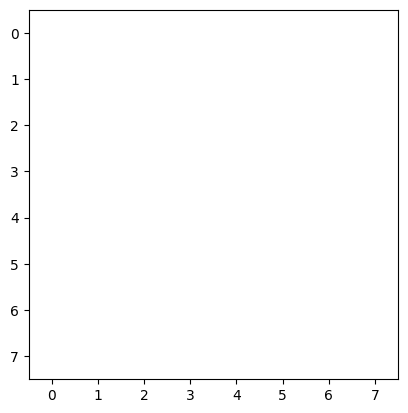

In [145]:
rng = np.random.default_rng(42)
random_index = np.random.randint(0, num_variables)
random_activation = np.copy(data[random_index]) * 0.01 + rng.normal(0, 1, data.shape[1]) 
random_activation = np.array([Langevin(x) for x in random_activation])
plt.imshow(random_activation.reshape(8,8), cmap='gray_r')
plt.show()

def relax(network, input=None, bias=None, inverse_temperature=1, least_action=False, max_steps=1000, tol=0.99):
    # house keeping
    nw = deepcopy(network)
    if input is not None:
        for i, node in enumerate(nw.sigmas):
            node.activation = input[i]
    if bias is not None:
        for i, node in enumerate(nw.sigmas):
            node.bias = bias[i]

    prev_act = np.zeros(len(nw.sigmas))
    for i in range(max_steps):
        print(nw.energy())
        nw.update(inverse_temperature=inverse_temperature, least_action=least_action)
        act = np.array([node.activation for node in nw.sigmas])
        if np.corrcoef(act, prev_act)[0, 1] > tol:
            return act, i
        prev_act = act
    return np.repeat(np.nan, len(nw.sigmas)), max_steps

att, step = relax(nw, random_activation, inverse_temperature=0.05, least_action=True, max_steps=100, tol=0.999)
plt.imshow(att.reshape(8,8), cmap='gray_r')
plt.show()